# GBDT for Regression

In [1]:
import numpy as np

class TreeNode:
    def __init__(self, findex, fvalue, left, right, value):
        
        assert value is not None
        
        self.left=left
        self.right=right
        self.findex=findex
        self.fvalue=fvalue
        self.value=value
    
    def getValue(self, X):
        '''
        X the features tuple
        '''
        left=self.left
        right =self.right
        value = self.value
        
        if left is None and right is None:
            return value
        
        x=X[self.findex]
        if x < self.fvalue:
            if left is None:
                return self.value
            else:
                return left.getValue(X)
        else: # x >= self.fvalue
            if right is None:
                return self.value
            else:
                return right.getValue(X)
    
    
    

class GBDT:
    
    def __init__(self):
        self.fs = []

    def cal_g(self, gpredictor, X, out=None):
        if out is None:
            yhat=np.zeros(X.shape[0])
            for idata in range(X.shape[0]):
                yhat[idata] = gpredictor.getValue(X[idata,:])            
            return yhat
        else:
            for idata in range(X.shape[0]):
                out[idata] = gpredictor.getValue(X[idata,:])            

    def add_cal_g(self, gpredictor, X, scale, out):
        for idata in range(X.shape[0]):
            out[idata] += scale*gpredictor.getValue(X[idata,:])            

        
    def get_F(self, X):
        '''
        return F
        '''
        assert len(X.shape) == 2
        assert X.shape[0] >= 1, str(X.shape)
        
        yhat=np.zeros(X.shape[0])
        for f in self.fs:        
            for idata in range(X.shape[0]):
                yhat[idata] += f.getValue(X[idata,:])*self.learning_rate
        return yhat
        
    def get_g(self, X, y, yhat):
        '''
        d MSE / d yhat = (yhat-y)
        '''
        assert X.ndim == 2
        assert y.ndim == 1
        assert X.shape[0] == y.shape[0]
        return yhat - y
    
    
    def fit_minusg(self, X, g, depth):
        
        assert X.ndim == 2, X.shape
        assert g.ndim == 1, g.shape
        assert X.shape[0] == g.shape[0]
        assert X.shape[0] >= 1, str(X.shape)
         
        #print("depth %d, X %d" % (depth, X.shape[0]))
            
        g_mean = np.mean(g)
        if depth == self.max_depth:
            return TreeNode(None,None,None,None, g_mean)

        if X.shape[0] == 1:
            # only one example
            f_min = -1
            i_min = -1
            x_min = -1
            g = TreeNode(None,None,None,None, g_mean)
            #print("depth %d, feature %d, value %f"%(depth, f_min, x_min))
        else:
            # we have at least 2 examples

            var_min = np.inf  # min variance
            f_min = -1 # feature index
            x_min = -1 # feature value of ith data

            sum_g = np.sum(g)
            mean_g = sum_g/g.shape[0]
            sum_g2 = np.sum(np.square(g))

            for findex in range(X.shape[1]): # for all features of X
                x=X[:,findex]
                
                pert=np.argsort(x)
                x_sort=x[pert]
                g_sort=g[pert]                
                #print(x_sort)
                #print(g_sort)
                
                Nminus1=g_sort.shape[0]-1
                gprime = g_sort[0:Nminus1]
                acc_g=np.add.accumulate(gprime)
                res_g=sum_g-acc_g
                #print("acc_g", acc_g)
                #print("res_g", res_g)

                # leftN = [1 2 3 ... N-1]
                # rightN = [N-1 N-2 ... 1]
                leftN=np.arange(1, Nminus1+1)
                rightN=np.arange(Nminus1,0,-1)
                #print(leftN)
                #print(rightN)

                # total var = acc_g2 - acc_g**2/nleft + res_g2 - res_g**2/nright
                # total var = total g2 - acc_g**2/nleft  - res_g**2/nright
                tot_var = sum_g2 - np.square(acc_g)/leftN - np.square(res_g)/rightN
                #print("tot_var", tot_var)

                # find the split point
                a_i_min = np.argmin(tot_var)
                a_var_min = tot_var[a_i_min]
                #print(a_var_min)
               
                if a_var_min < var_min:
                    var_min=a_var_min
                    f_min = findex
                    x_min = 0.5*(x_sort[a_i_min]+x_sort[a_i_min+1])


            # split data
            # each side has at least one example
            Xf=X[:,f_min]
            left_mask = (Xf < x_min)
            right_mask = np.logical_not(left_mask)
            Xleft=X[left_mask]
            gleft=g[left_mask]        
            Xright=X[right_mask]
            gright=g[right_mask]

            #print(Xleft.shape)
            #print(gleft.shape)
            #print("depth %d, feature %d, value %f, left %d, right %d"%(depth, f_min, x_min, len(Xleft), len(Xright)))
            leftNode=self.fit_minusg(X=Xleft, g=gleft, depth=depth+1)
            rightNode=self.fit_minusg(X=Xright, g=gright, depth=depth+1)
            
            g=TreeNode(f_min, x_min, leftNode, rightNode, g_mean)
                               
        return g;
    
    
    def fit(self,X, y, learning_rate=0.1, max_iteration=100, max_depth=2):        
        assert X.ndim == 2, X.shape
        assert y.ndim == 1, y.shape
        assert X.shape[0] == y.shape[0], X.shape
        
        self.learning_rate=learning_rate
        self.max_depth=max_depth
        yhat=np.zeros(y.shape[0])
        for iter in range(max_iteration):
            g=self.get_g(X,y,yhat)
            gpredictor=self.fit_minusg(X, -g, 1)
            self.add_cal_g(gpredictor, X, self.learning_rate, yhat)
            self.fs.append(gpredictor)
    
    
    def predict(self,X):
        return self.get_F(X)


# 1-D fit

In [2]:
import matplotlib.pyplot as plt
NTRAIN=200

def get_X(n):
    X=2*np.pi*np.random.rand(n)
    return X

def get_y(X):
    y = np.sin(X) + 0.2*np.random.randn(X.shape[0])
    return y

X_train=get_X(NTRAIN)
y_train=get_y(X_train)

gbdt=GBDT()
gbdt.fit(X_train.reshape(-1,1), y_train, learning_rate=0.05, max_iteration=400, max_depth=2)
yhat_plt=gbdt.predict(np.linspace(0,2*np.pi).reshape(-1,1))

plt.figure()
plt.scatter(X_train,y_train,color='blue')
plt.plot(np.linspace(0,2*np.pi),yhat_plt,color='red')
plt.show()


<Figure size 640x480 with 1 Axes>

# 2-D fit

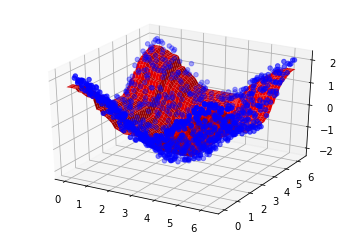

In [3]:
NTRAIN=1000

def get_X(n):
    X=2*np.pi*np.random.rand(n,2)
    return X

def get_y(X):
    y = np.cos(X[:,0]) + np.cos(X[:,1])
    y = y + 0.1*np.random.randn(X.shape[0])
    return y

X_train = get_X(NTRAIN)
y_train = get_y(X_train)

gbdt=GBDT()
gbdt.fit(X_train, y_train, learning_rate=0.1, max_iteration=200, max_depth=2)

X_grid = np.linspace(0,2*np.pi,50)
Y_grid = np.linspace(0,2*np.pi,50)
xx,yy = np.meshgrid(X_grid, Y_grid)
yhat_plt=gbdt.predict(np.c_[xx.flatten(),yy.flatten()])

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0],X_train[:,1], y_train,color='blue')
ax.plot_surface(xx, yy, yhat_plt.reshape(50,50),color='red')
plt.show()


In [4]:
#import profile
#profile.run("gbdt.fit(X_train, y_train, learning_rate=0.1, max_iteration=200, max_depth=2)") 